### Congratulations! You have been hired as a consutant to assit a Hedge Fund manager in optimizing a portfio containing Apple, Microsoft, Google, Nvidia. Your goal is to find the proper weights that will generate a "good" return for the portfolio. WHat to take into consideration is that the manager does not like to take much rrisk but would consider is the returns for this portfilio would be significant. 

### Use your knowledge to look into allocating the weights for the portfolio that would suit his/her interest

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
import numpy as np

In [97]:
tickers = ["AAPL", "MSFT", "GOOG", "NVDA"]

In [98]:
data = pd.DataFrame()
for t in tickers:
    data[t] = web.DataReader(t, data_source="yahoo", start="2009-1-1")["Adj Close"]

In [99]:
data.head()

,AAPL,MSFT,GOOG,NVDA
Date,,,,
2009-01-02,11.253528,15.592469,160.060059,8.016504
2009-01-05,11.728474,15.738195,163.412491,8.163763
2009-01-06,11.535025,15.922266,166.406265,8.439878
2009-01-07,11.285772,14.963554,160.403763,7.933669
2009-01-08,11.495339,15.431399,161.987823,7.731187


## Normal Returns
- Calculate the normal returns for the portfilio containing the 4 selected securties

In [100]:
for t in tickers:
    data[f"{t} normal returns"] = data[f"{t}"]/data[f"{t}"].iloc[0]

In [101]:
data.head()

,AAPL,MSFT,GOOG,NVDA,AAPL normal returns,MSFT normal returns,GOOG normal returns,NVDA normal returns
Date,,,,,,,,
2009-01-02,11.253528,15.592469,160.060059,8.016504,1.000000,1.000000,1.000000,1.000000
2009-01-05,11.728474,15.738195,163.412491,8.163763,1.042204,1.009346,1.020945,1.018369
2009-01-06,11.535025,15.922266,166.406265,8.439878,1.025014,1.021151,1.039649,1.052813
2009-01-07,11.285772,14.963554,160.403763,7.933669,1.002865,0.959665,1.002147,0.989667
2009-01-08,11.495339,15.431399,161.987823,7.731187,1.021488,0.989670,1.012044,0.964409


In [102]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AAPL normal returns,MSFT normal returns,GOOG normal returns,NVDA normal returns
Date,,,,,,,,
2020-04-27,283.170013,174.050003,1275.880005,297.079987,25.162778,11.162440,7.971258,37.058545
2020-04-28,278.579987,169.809998,1233.670044,291.359985,24.754903,10.890514,7.707545,36.345017
2020-04-29,287.730011,177.429993,1341.479980,298.459991,25.567984,11.379211,8.381104,37.230691
2020-04-30,293.799988,179.210007,1348.660034,292.279999,26.107368,11.493369,8.425962,36.459782
2020-05-01,289.070007,174.570007,1320.609985,282.779999,25.687057,11.195790,8.250715,35.274727


### Portfolio Allocaiton 
- What percent of the portfolio is made up by each security.
- We will select arbritrary weights and later find the best weighted portfolio
- weights = 2% Apple, 4% Mirosoft, 3% Google ,1% Nvidia

In [103]:
weights = [0.2,0.4,0.3,0.1]
for stock, allocation in zip(tickers,weights):
    data[f"{stock} allocation"] = data[f"{stock} normal returns"] * allocation

In [104]:
data.head()

,AAPL,MSFT,GOOG,NVDA,AAPL normal returns,MSFT normal returns,GOOG normal returns,NVDA normal returns,AAPL allocation,MSFT allocation,GOOG allocation,NVDA allocation
Date,,,,,,,,,,,,
2009-01-02,11.253528,15.592469,160.060059,8.016504,1.000000,1.000000,1.000000,1.000000,0.200000,0.400000,0.300000,0.100000
2009-01-05,11.728474,15.738195,163.412491,8.163763,1.042204,1.009346,1.020945,1.018369,0.208441,0.403738,0.306283,0.101837
2009-01-06,11.535025,15.922266,166.406265,8.439878,1.025014,1.021151,1.039649,1.052813,0.205003,0.408460,0.311895,0.105281
2009-01-07,11.285772,14.963554,160.403763,7.933669,1.002865,0.959665,1.002147,0.989667,0.200573,0.383866,0.300644,0.098967
2009-01-08,11.495339,15.431399,161.987823,7.731187,1.021488,0.989670,1.012044,0.964409,0.204298,0.395868,0.303613,0.096441


In [105]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AAPL normal returns,MSFT normal returns,GOOG normal returns,NVDA normal returns,AAPL allocation,MSFT allocation,GOOG allocation,NVDA allocation
Date,,,,,,,,,,,,
2020-04-27,283.170013,174.050003,1275.880005,297.079987,25.162778,11.162440,7.971258,37.058545,5.032556,4.464976,2.391377,3.705855
2020-04-28,278.579987,169.809998,1233.670044,291.359985,24.754903,10.890514,7.707545,36.345017,4.950981,4.356205,2.312263,3.634502
2020-04-29,287.730011,177.429993,1341.479980,298.459991,25.567984,11.379211,8.381104,37.230691,5.113597,4.551684,2.514331,3.723069
2020-04-30,293.799988,179.210007,1348.660034,292.279999,26.107368,11.493369,8.425962,36.459782,5.221474,4.597348,2.527789,3.645978
2020-05-01,289.070007,174.570007,1320.609985,282.779999,25.687057,11.195790,8.250715,35.274727,5.137411,4.478316,2.475215,3.527473


### Position 
- Will calculate the position in this portfolio if we were to invest 200,000 in this portfolio

In [106]:
for s in tickers:
    data[f"{s} position"] = data[f"{s} allocation"] * 200000

### Total Position
- We will calculate the total positon on a daily basis for the portfolio

In [108]:
data["total position"] = data[["AAPL position","MSFT position","GOOG position","NVDA position"]].sum(axis=1)

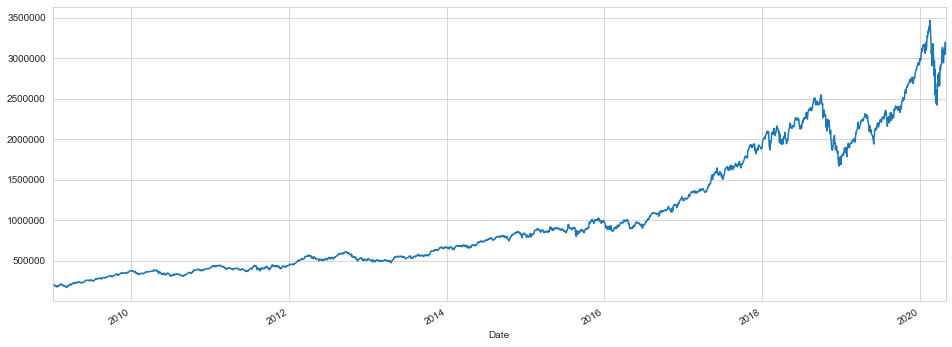

In [109]:
data["total position"].plot(figsize = (16,6))

#### Total Position Overtime 
- A 200K investment in a this portfolio since 2009 would have made you 3M today

In [110]:
data["total position"].tail()

Date
2020-04-27    3.118953e+06
2020-04-28    3.050790e+06
2020-04-29    3.180536e+06
2020-04-30    3.198518e+06
2020-05-01    3.123683e+06
Name: total position, dtype: float64

### Daily Portfolio Returns
- We will calculate the datil returs for the portfolio 
- The histagram shows that there is not too much volatility in the portfolio 
- Most this portfilio has lost is approximately 5-6% 

In [111]:
data["daily returns"] = data["total position"].pct_change()

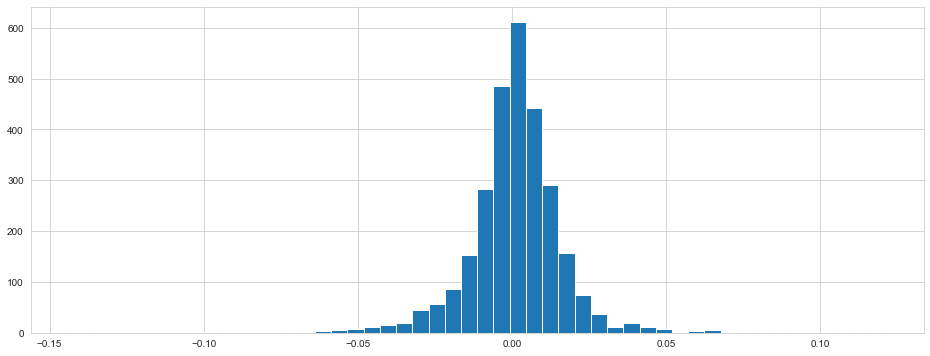

In [112]:
data["daily returns"].hist(figsize = (16,6), bins = 50)

### Sharp Ratio
 - Sharp ratio measures the relation of returns to volatility 
 - We will calculate the sharp with the portfio we have developed with our arbritrary weights
 - We get a sharp of 1.13 which is pretty good

In [113]:
port_volatility  = data["daily returns"].std()

In [114]:
port_mean_daily_returns = data["daily returns"].mean()

In [115]:
sharp = (port_mean_daily_returns/port_volatility) * np.sqrt(252)

In [116]:
sharp

1.1309880694886065

### Randomly Weighted Portfolios
- We will use python to generate 2000 portfolios to see if we can improve on the Sharp

In [117]:
data.columns

Index(['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AAPL normal returns',
       'MSFT normal returns', 'GOOG normal returns', 'NVDA normal returns',
       'AAPL allocation', 'MSFT allocation', 'GOOG allocation',
       'NVDA allocation', 'AAPL position', 'MSFT position', 'GOOG position',
       'NVDA position', 'total position', 'daily returns'],
      dtype='object')

In [118]:
securties = data[['AAPL', 'MSFT', 'GOOG', 'NVDA']]

In [119]:
port_returns = securties.pct_change()

In [120]:
port_returns

,AAPL,MSFT,GOOG,NVDA
Date,,,,
2009-01-02,NaN,NaN,NaN,NaN
2009-01-05,0.042204,0.009346,0.020945,0.018369
2009-01-06,-0.016494,0.011696,0.018320,0.033822
2009-01-07,-0.021608,-0.060212,-0.036071,-0.059978
2009-01-08,0.018569,0.031266,0.009875,-0.025522
...,...,...,...,...
2020-04-27,0.000707,-0.002865,-0.002681,0.025864
2020-04-28,-0.016209,-0.024361,-0.033083,-0.019254
2020-04-29,0.032845,0.044874,0.087390,0.024369


In [121]:
n_portfolios = 2000 
all_weights = np.zeros((n_portfolios, len(tickers)))
all_returns = np.zeros(n_portfolios)
all_vol = np.zeros(n_portfolios)
all_sharp = np.zeros(n_portfolios)

for ind in range(n_portfolios):
    weights = np.array(np.random.random(4))
    weights = weights/weights.sum()
    
    all_weights[ind,:] = weights
    
    all_returns[ind] = np.sum(port_returns.mean() * weights) * 252 
    all_vol[ind] = np.sqrt(np.dot(weights.T, np.dot(port_returns.cov() * 252, weights)))
    all_sharp[ind] = all_returns[ind]/all_vol[ind]

## Best Sharp
- We will use the 2000 to find which has the 
- max sharp, lowest Vol, and the max returns

In [122]:
max_sharp = all_sharp.argmax()

In [123]:
lowest_vol= all_vol.argmin()

In [124]:
max_returns = all_returns.argmax()

## Plotting portfolios 
- Will plot all 2000 portfolios as well as the 3 portfolios listed above 

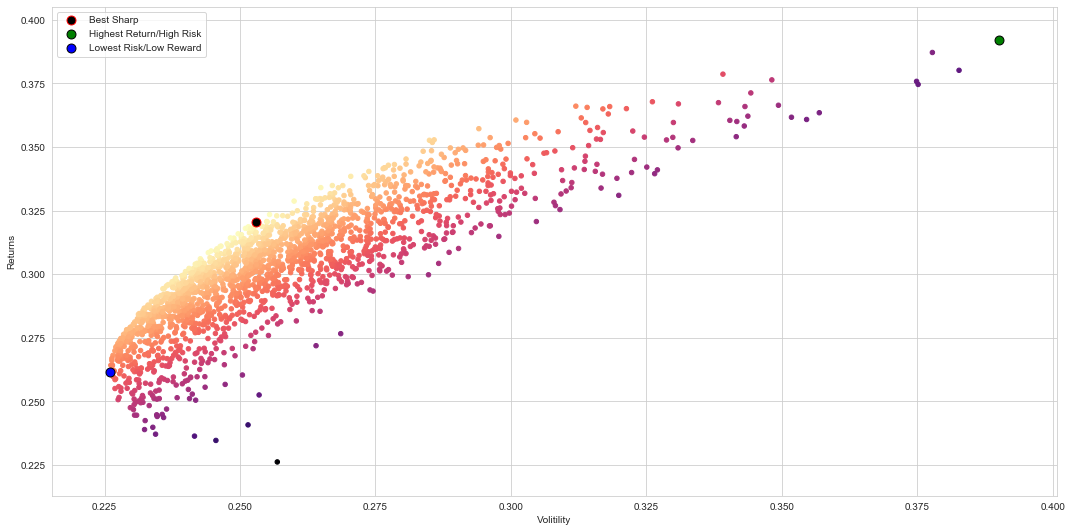

In [140]:
plt.figure(figsize=(18,9))
plt.scatter(all_vol, all_returns, c=all_sharp, cmap="magma", s = 20)
plt.colorbar= True
plt.xlabel("Volitility")
plt.ylabel("Returns")
plt.scatter(all_vol[max_sharp], all_returns[max_sharp], c = "black", s = 80, edgecolor = "red", label = "Best Sharp")
plt.scatter(all_vol[max_returns], all_returns[max_returns], c = "green", s = 80, edgecolor = "black", label = "Highest Return/High Risk")
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c = "blue", s = 80, edgecolor = "black", label = "Lowest Risk/Low Reward")
plt.legend();

### Mathmatically 
- Random Allocaitons of a portfolio is great but could lask when a portfolio has 100 securties 
- We will use scipy for a portfolio optimization

In [141]:
from scipy.optimize import minimize

## Helper Functions
- These functions will assit in optimizing the weights of the portfolio

In [188]:
def get_sharp(weights):
    weights = np.array(weights)
    ret = np.sum(port_returns.mean() *weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(port_returns.cov() * 252,weights)))
    shp = ret/vol 
    return np.array([ret,vol,shp])

In [189]:
def check_weights(weights):
    return np.sum(weights) - 1

In [190]:
def improve_sharp(weights):
    return get_sharp(weights)[2] * -1

In [191]:
const = ({"type":"eq", "fun":check_weights})

In [192]:
bounds = ((0,1),) * len(tickers)
bounds

((0, 1), (0, 1), (0, 1), (0, 1))

In [193]:
initial_guess = [0.25] * len(tickers)
initial_guess

[0.25, 0.25, 0.25, 0.25]

In [194]:
optimal_results = minimize(improve_sharp, initial_guess, method="SLSQP",constraints=const, bounds=bounds)

### Minimize Results 
- States the max sharp we can get out of this portfilio is 1.26
- Weights are listed as the "x" values
- we will see how these compare to the random allocation results

In [195]:
optimal_results

     fun: -1.2677624546739144
     jac: array([ 1.09195709e-04, -5.17964363e-05,  3.26305628e-04, -3.28898430e-04])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.56405079, 0.22965267, 0.02769669, 0.17859984])

## Minimize funciton - Weight prediciton

In [196]:
optimal_results.x

array([0.56405079, 0.22965267, 0.02769669, 0.17859984])

## Random Allocated - best sharp
- Weights that will generate the best sharp

In [197]:
all_weights[max_sharp]

array([0.55684397, 0.23937404, 0.0248493 , 0.17893268])

### MAX Sharp
- Both Random allocaiton as well as the minimize had similar predicitons 

In [200]:
np.abs(optimal_results["fun"])

1.2677624546739144

In [199]:
all_sharp[max_sharp]

1.2677140304304717

### Efficient Frontier
- We will use the Minimize function to get the efficient frontier

In [207]:
frontier_y = np.linspace(0.22,.40,200)

In [208]:
def min_vol(weights):
    return get_sharp(weights)[1]

In [222]:
frontier_vol = []

In [223]:
frontier_weights = []

## Minimize - Efficient Frontier
- The below calculation will gather the max return at any selected Volatility
- An investor could select a volatility of choosing ang gather the associated Return

In [224]:
for potential_return in frontier_y:
    cons = ({"type":"eq", "fun": check_weights}, 
            {"type":"eq", "fun": lambda x: get_sharp(x)[0] - potential_return})
    best_result = minimize(min_vol,initial_guess,method="SLSQP", constraints=cons, bounds=bounds)
    frontier_vol.append(best_result["fun"])
    frontier_weights.append(best_result.x)

### Final Decision: 
- Would Highly recommend that the investor look at the portfolio with the highest sharp ratio colored black below. This would generate the maximum return with at minimim volatility.
- If this is still too much of risk a portfolio with a low rish could be considered such as the one in blue. 
- And if this is still not satisfying the Scipy function below generated a frontier that can be selected from

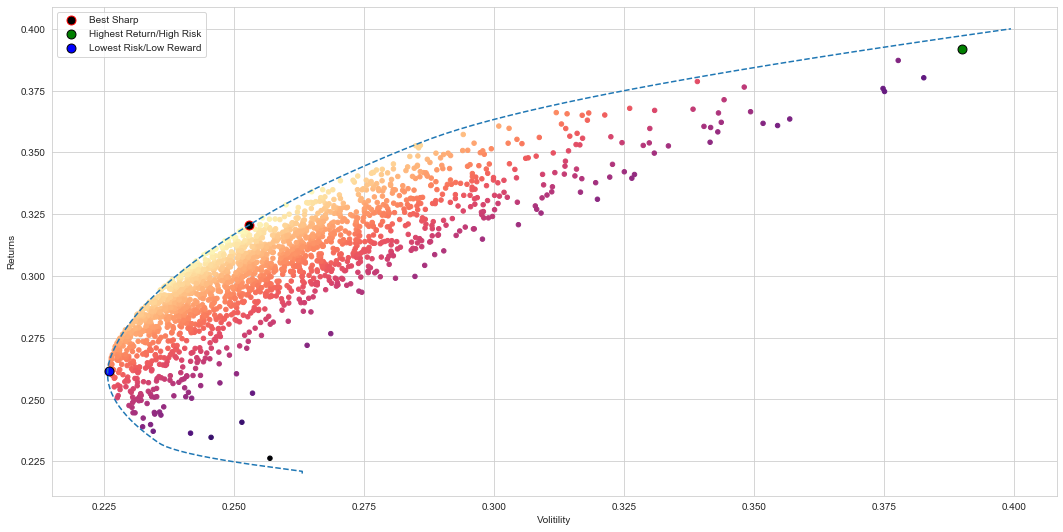

In [225]:
plt.figure(figsize=(18,9))
plt.scatter(all_vol, all_returns, c=all_sharp, cmap="magma", s = 20)
plt.colorbar= True
plt.xlabel("Volitility")
plt.ylabel("Returns")
plt.scatter(all_vol[max_sharp], all_returns[max_sharp], c = "black", s = 80, edgecolor = "red", label = "Best Sharp")
plt.scatter(all_vol[max_returns], all_returns[max_returns], c = "green", s = 80, edgecolor = "black", label = "Highest Return/High Risk")
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c = "blue", s = 80, edgecolor = "black", label = "Lowest Risk/Low Reward")
plt.plot(frontier_vol, frontier_y, ls = "--")
plt.legend();

### Efficient Frontier Data Frame

In [230]:
frontier_weights_predictied = pd.DataFrame(frontier_weights)

In [231]:
frontier_weights_predictied.columns = ["AAPL","MSFT","GOOG","NVDA"]

In [232]:
frontier_weights_predictied

,AAPL,MSFT,GOOG,NVDA
0,2.581269e-14,0.000000e+00,1.000000e+00,0.000000e+00
1,1.818398e-17,2.179101e-17,1.000000e+00,6.947392e-16
2,6.383782e-16,2.981464e-02,9.701854e-01,0.000000e+00
3,3.885781e-16,6.284627e-02,9.371537e-01,0.000000e+00
4,5.551115e-16,9.587789e-02,9.041221e-01,0.000000e+00
...,...,...,...,...
195,1.811629e-01,0.000000e+00,0.000000e+00,8.188371e-01
196,1.705007e-01,0.000000e+00,2.775558e-17,8.294993e-01
197,1.598385e-01,1.387779e-16,0.000000e+00,8.401615e-01
198,1.491763e-01,0.000000e+00,0.000000e+00,8.508237e-01


In [215]:
frontier_returns = pd.DataFrame(frontier_y)
frontier_returns["vol"] = frontier_vol

In [217]:
frontier_returns.columns = ["returns","volatility"]

In [233]:
frontier_Optmized = pd.concat([frontier_returns,frontier_weights_predictied], axis=1)

### Efficiency Final 
- Returns 
- Volatility 
- Associated Weights 
- Are we increase returns volatility increases. "Higher Risk Higher Return"
- WE also see that for a max retun for this portfolio the weights for MSFT and GOOG are pretty much 0

In [249]:
frontier_Optmized[frontier_Optmized["returns"] > 0.385]

,returns,volatility,AAPL,MSFT,GOOG,NVDA
183,0.385528,0.353613,0.309109,2.775558e-17,0.000000e+00,0.690891
184,0.386432,0.356273,0.298447,0.000000e+00,0.000000e+00,0.701553
185,0.387337,0.358964,0.287785,1.110223e-16,0.000000e+00,0.712215
186,0.388241,0.361686,0.277123,8.326673e-17,2.775558e-17,0.722877
187,0.389146,0.364436,0.266460,0.000000e+00,0.000000e+00,0.733540
188,0.390050,0.367215,0.255798,0.000000e+00,5.551115e-17,0.744202
189,0.390955,0.370021,0.245136,8.326673e-17,0.000000e+00,0.754864
190,0.391859,0.372855,0.234474,0.000000e+00,2.775558e-17,0.765526
191,0.392764,0.375716,0.223812,2.775558e-17,0.000000e+00,0.776188
192,0.393668,0.378603,0.213149,2.775558e-17,1.387779e-16,0.786851
